Processing ECG 1: [1.      0.795   0.139   0.171   0.      0.0621  0.106   0.177   0.2
 0.181   0.199   0.201   0.208   0.196   0.195   0.18    0.205   0.191
 0.173   0.162   0.162   0.162   0.17    0.157   0.173   0.162   0.134
 0.125   0.124   0.123   0.123   0.0952  0.103   0.107   0.105   0.119
 0.119   0.105   0.136   0.19    0.217   0.253   0.276   0.261   0.286
 0.297   0.299   0.306   0.296   0.298   0.31    0.321   0.324   0.317
 0.325   0.321   0.326   0.325   0.339   0.322   0.326   0.311   0.323
 0.334   0.32    0.31    0.32    0.321   0.346   0.331   0.332   0.338
 0.347   0.349   0.369   0.347   0.356   0.349   0.35    0.361   0.358
 0.366   0.355   0.345   0.332   0.354   0.366   0.349   0.36    0.341
 0.327   0.35    0.348   0.356   0.348   0.342   0.328   0.319   0.33
 0.299   0.321   0.326   0.312   0.314   0.331   0.323   0.335   0.319
 0.316   0.328   0.325   0.318   0.292   0.296   0.324   0.367   0.405
 0.471   0.531   0.525   0.628   0.621   0.557   0.474   0.418

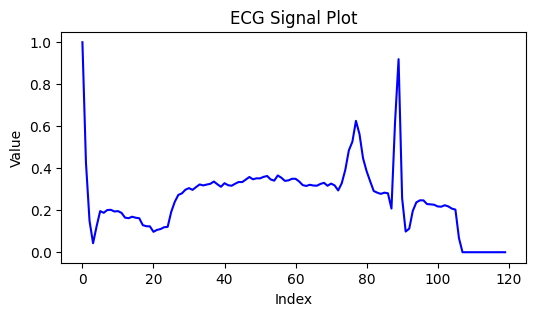

In [11]:

import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import joblib  # for loading saved scaler
import tkinter as tk
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

# ----------------------------
# Step 1: Load trained model
# ----------------------------
model = load_model("ecg_cnn_model.keras")

# ----------------------------
# Step 2: Load saved scaler
# ----------------------------
scaler = joblib.load("scaler.pkl")  # saved after training

# ----------------------------
# Step 3: Load new ECG test data
# ----------------------------
new_df = pd.read_csv(r"data_sets\ecg3.csv", header=None, dtype=str)

processed_signals = []
target_len = 120  # same as used in training

def to_signed24(x):
            if x & 0x800000:  # if sign bit (bit 23) is set
                x -= 0x1000000  # subtract 2^24 to sign-extend
            return x*2.4*2/(2**23)


def resize_signal(signal, target_len):
    # Original indices
    old_indices = np.linspace(0, 1, len(signal))
    # New indices for target length
    new_indices = np.linspace(0, 1, target_len)
    # Interpolation
    expanded = np.interp(new_indices, old_indices, signal)
    return expanded


def plot_array_gui(signal, title="Signal Plot"):
    # Create Tkinter window
    root = tk.Tk()
    root.title(title)

    # Create matplotlib figure
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(signal, color="blue")
    ax.set_title(title)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")

    # Embed the figure in Tkinter
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    # Start GUI loop
    root.mainloop()

# ----------------------------
# Step 4: Preprocess each row
# ----------------------------
for idx, row in new_df.iterrows():
    # Convert to numeric, replace bad/malformed values with 0
    signal_ = pd.to_numeric(row, errors='coerce').fillna(0).values.flatten()
    #corrected_signal = np.array([to_signed24(int(x)) for x in signal_])
    corrected_signal = signal_
    nomalized_signal = (corrected_signal-np.min(corrected_signal)) / (np.max(corrected_signal) - np.min(corrected_signal))
    
    print(f"Processing ECG {idx+1}: {nomalized_signal}")
    signal = nomalized_signal
    # Pad or truncate to target length
    
    resized_signal = resize_signal(signal, target_len)   
    print(f"Processing ECG0 {idx+1}: {resized_signal}") 
    processed_signals.append(resized_signal)


# Stack all signals for CNN input
new_X = np.stack(processed_signals)

# ----------------------------
# Step 5: Normalize using saved scaler
# ----------------------------
new_X = scaler.transform(new_X)

# Reshape for CNN input
new_X = new_X[..., np.newaxis]  # shape: (samples, signal_length, 1)

# ----------------------------
# Step 6: Predict
# ----------------------------
predictions = model.predict(new_X)
print("Predictions shape:", predictions.shape)
predicted_labels = (predictions > 0.5).astype(int)

# ----------------------------
# Step 7: Show predictions
# ----------------------------
results = []
for i, p in enumerate(predicted_labels):
    label = 'Abnormal' if p[0] == 1 else 'Normal'
    print(f"ECG signal {i+1}: {label}")
    results.append([i+1, label])

# ----------------------------
# Step 8: Save predictions to CSV
# ----------------------------
results_df = pd.DataFrame(results, columns=['ECG_ID', 'Prediction'])
results_df.to_csv("ecg_test_predictions.csv", index=False)
print("Predictions saved to 'ecg_test_predictions.csv'.")

plot_array_gui(resized_signal, "ECG Signal Plot")